# CLASIFICACION GRADIENT BOOSTING 


In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.datasets import make_classification

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_curve 
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import balanced_accuracy_score

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

import warnings
import importlib
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
import IPython
import IPython.display

In [3]:
from xgboost import XGBClassifier

In [4]:
def compute_metrics_classification(y, y_pred_label, average='binary'):
    acc = accuracy_score(y, y_pred_label)
            
    presicion = precision_score(y, y_pred_label, average=average)
    recall = recall_score(y, y_pred_label, average=average)
    balanced = balanced_accuracy_score(y, y_pred_label)        
    return {'acc':acc, 'presicion':presicion, 'recall':recall, 'balanced':balanced}
    
def compute_curves(y, y_pred_prob, pos_label=1, plot=False):
    precision, recall_tpr_0, thresholds = precision_recall_curve(y, y_pred_prob[:, pos_label], pos_label=pos_label)
    print('precision-recall curve for the class ', pos_label)
    
    fpr, recall_tpr_1, thresholds = roc_curve(y, y_pred_prob[:,pos_label], pos_label=pos_label)
    
    if plot:
        fig, ax = plt.subplots(1, 2, figsize=(15, 6)) 
        ax[0].plot(recall_tpr_0, precision)
        ax[0].set_xlabel('Recall')
        ax[0].set_ylabel('Presicion')
        ax[0].set_title('Presicion - Recall curve')
        ax[1].plot(fpr, recall_tpr_1)
        ax[1].set_xlabel('1-TNR')
        ax[1].set_ylabel('Recall')
        ax[1].set_title('ROC curve')
    
    return {'pr_curve': auc(recall_tpr_0, precision), 'roc_curve':auc(fpr, recall_tpr_1)}
    
def predict_classes(y_prob):
    return np.argmax(y_prob, axis=1), np.max(y_prob, axis=1)    

def compute_metrics_sklearn(y, y_pred_label, average='binary'):
    acc = accuracy_score(y, y_pred_label)
            
    presicion = precision_score(y, y_pred_label, average=average)
    recall = recall_score(y, y_pred_label, average=average)
    balanced = balanced_accuracy_score(y, y_pred_label)        
    return {'acc':acc, 'presicion':presicion, 'recall':recall, 'balanced':balanced}    

def ploting_probilities_surfaces(X, y, model, show_data=True,figsize=(10, 8)):
# def ploting_probilities_surfaces(X, y, predict_class, predict_prob, show_data=True):    
    
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))        
    space_to_plot = np.c_[xx.ravel(), yy.ravel()]
    
    Z_temp = np.int_(np.argmax(model.predict_proba(space_to_plot), axis=1))
    #return Z_temp 
    Z_predict = Z_temp.reshape(xx.shape)

    
    Z_prob = model.predict_proba(space_to_plot)
    #Z_prob = predict_prob
    Z_prob = Z_prob[np.arange(Z_temp.shape[0]), Z_temp]
    
    Z_prob = Z_prob.reshape(xx.shape)

    fig = plt.figure()
    plt.figure(figsize=figsize, dpi= 80, facecolor='w', edgecolor='k')
    plt.contourf(xx, yy, Z_predict, cmap=plt.cm.Spectral, alpha=0.8)
    if show_data == True:
        plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    fig = plt.figure()
    plt.figure(figsize=figsize, dpi= 80, facecolor='w', edgecolor='k')
    plt.contourf(xx, yy, Z_prob, cmap=plt.cm.Spectral, alpha=0.8)
    if show_data == True:
        plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


# 1. Datos para clasificacion

## $$\{\pmb{x_i}, y_i\}_{i=1}^N~~;~\pmb{x_i}\in R^D, y_i = 1, 2,...,K$$

In [5]:
df_train, df_target = make_classification(
    n_samples = 1000,
    n_features=2,
    n_informative=2, #1
    n_redundant=0,
    n_classes=4, #4 #2
    n_clusters_per_class=1,
    random_state=42,
)

df_train = pd.DataFrame(df_train)
df_train.columns = ['feat_'+str(i) for i in range(df_train.shape[1])]

df_target = pd.DataFrame(df_target)
df_target.columns = ['target']

df_train = df_train.fillna(0.0)
df_target = df_target.fillna(0.0)

print("data size: ", df_train.shape, df_target.shape)
display(df_train.sample(10))
display(df_target.sample(10))

data size:  (1000, 2) (1000, 1)


,feat_0,feat_1
773,1.296164,1.387867
750,1.594303,-1.185235
101,-1.136700,-1.731974
961,-0.667100,-0.101677
943,-1.134789,-1.088779
694,0.838253,-0.844179
104,-0.545329,0.665287
387,2.169180,-0.562336
959,1.006780,-0.321469
895,0.619803,-1.348164


,target
269,0
341,0
89,0
173,1
682,0
277,2
362,0
157,3
668,0
716,1


# 2. Preprocesamiento:  Feature scaling
* Remover la media (media=0) 
* Escalar la variance (var=1)

In [6]:
## Split training and test datasets.

X_train, X_test, Y_train, Y_test = train_test_split(df_train, df_target, test_size=0.1, random_state=0)

## scale features
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index)
X_train_scaled.columns = X_train.columns

X_test_scaled = pd.DataFrame(scaler.transform(X_test), index=X_test.index)
X_test_scaled.columns = X_test.columns   


x_train, x_val, y_train, y_val = train_test_split(X_train_scaled, Y_train, test_size=0.2, random_state=0)

print('partition 1: ', 'X_train:', X_train_scaled.shape, ' X_test:', X_test.shape)
print('partition 2: ', 'X_train:', x_train.shape, ' x_val: ', x_val.shape)

partition 1:  X_train: (900, 2)  X_test: (100, 2)
partition 2:  X_train: (720, 2)  x_val:  (180, 2)


Text(0, 0.5, 'feat_1')

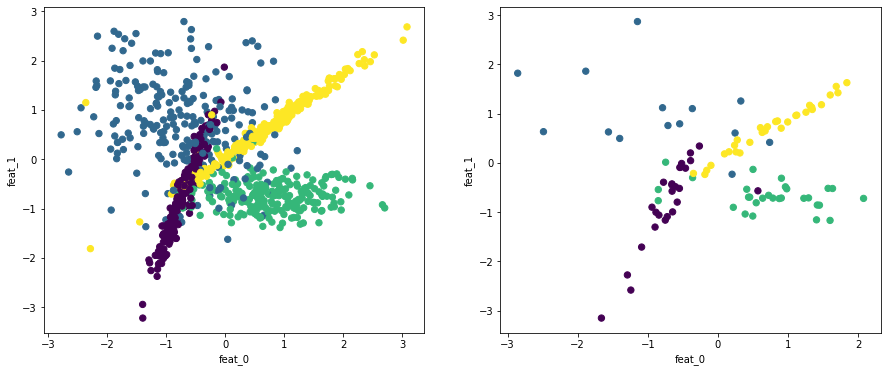

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6)) 
ax[0].scatter(X_train_scaled.values[:, 0], X_train_scaled.values[:, 1], c=Y_train.values, s=40)
ax[0].set_xlabel('feat_0')
ax[0].set_ylabel('feat_1')
ax[1].scatter(X_test_scaled.values[:, 0], X_test_scaled.values[:, 1], c=Y_test.values, s=40) #marker='s'
ax[1].set_xlabel('feat_0')
ax[1].set_ylabel('feat_1')

# 2. Model

## Approximated function: 

## $$f(\pmb{x_i}, \pmb{\theta}) = \sum_{m=0}^M \beta_{m}b(\pmb{x_i};\{\gamma_j, R_j\}_{j=1}^J)$$

Donde $b(.)$ es un arbol de decision 
## $$b(\pmb{x_i};\{\gamma_j, R_j\}_{j=1}^J) = \sum_{j=1}^J \gamma_{j}I(\pmb{x_i} \in R_j)$$

# 3. Entrenamiento

## Loss function
$$L(\{y_i, f_k(\pmb{x_i})\}_1^K)) = -\sum_{k=1}^K\log p_k(\pmb{x_i})$$, donde  $p_k(\pmb{x_i})$ es la softmax function

## Learning
### Approximate the solution by Forward Stagewise Additive Modeling
1. Initialize $f_0(\pmb{x}) = 0$
2. For $m=1$ to $M$    
    * $\beta_{m}, \gamma_{m} = argmin_{\beta, \gamma}\sum_{i=1}^N L(y_i, f_{m-1}(\pmb{x_i}) + \beta b(\pmb{x_i};\gamma))$
    * $f_m(\pmb{x_i}) = f_{m-1}(\pmb{x_i}) + \beta_{m}b(\pmb{x_i};\gamma_{m})$
 


In [8]:
param_tmp = {'learning_rate':0.1, 
              'max_depth': 9,  
              'min_child_weight':6, 
              'subsample': 0.8, 
              'colsample_bytree': 0.8, 
              'reg_alpha': 0.1,
              'n_estimators': 300} 

model = XGBClassifier(objective='multi:softmax', 
# model = XGBClassifier(objective='binary:logistic', 
                      learning_rate = param_tmp['learning_rate'], 
                         max_depth = param_tmp['max_depth'],
                         min_child_weight = param_tmp['min_child_weight'],
                         subsample = param_tmp['subsample'],
                         colsample_bytree = param_tmp['colsample_bytree'],
                         reg_alpha = param_tmp['reg_alpha'],
                         n_estimators = param_tmp['n_estimators']) 
    
eval_set = [(x_train.values, y_train.values), (x_val.values, y_val.values)]    
model.fit(x_train.values, y_train.values, 
          eval_set=eval_set,
          early_stopping_rounds=20)

[0]	validation_0-merror:0.320833	validation_1-merror:0.416667
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.181944	validation_1-merror:0.288889
[2]	validation_0-merror:0.205556	validation_1-merror:0.283333
[3]	validation_0-merror:0.181944	validation_1-merror:0.3
[4]	validation_0-merror:0.218056	validation_1-merror:0.333333
[5]	validation_0-merror:0.188889	validation_1-merror:0.3
[6]	validation_0-merror:0.179167	validation_1-merror:0.272222
[7]	validation_0-merror:0.180556	validation_1-merror:0.3
[8]	validation_0-merror:0.176389	validation_1-merror:0.261111
[9]	validation_0-merror:0.176389	validation_1-merror:0.261111
[10]	validation_0-merror:0.168056	validation_1-merror:0.25
[11]	validation_0-merror:0.172222	validation_1-merror:0.266667
[12]	validation_0-merror:0.163889	validation_1-merror:0.261111
[13]	validation_0-merror:0.161111	validation_1-

XGBClassifier(colsample_bytree=0.8, max_depth=9, min_child_weight=6,
              n_estimators=300, objective='multi:softprob', reg_alpha=0.1,
              subsample=0.8)

# 4 Evaluacion 

In [9]:
y_train_predict = model.predict_proba(X_train_scaled.values)
y_test_predict = model.predict_proba(X_test_scaled.values)

In [10]:
## compute metrics train
# dict_metrics_train = compute_metrics_classification(y_train_tmp, predict_classes(y_train_pred_prob)[0], average='binary')
dict_metrics_train = compute_metrics_classification(Y_train, predict_classes(y_train_predict)[0], average='macro')
dict_curves_train = compute_curves(Y_train, y_train_predict, pos_label=1)

## compute metrics test
# dict_metrics_test = compute_metrics_classification(y_test_tmp, predict_classes(y_test_pred_prob)[0], average='binary')
dict_metrics_test = compute_metrics_classification(Y_test, predict_classes(y_test_predict)[0], average='macro')
dict_curves_test = compute_curves(Y_test, y_test_predict, pos_label=1)

df_results_metrics = pd.DataFrame([dict_metrics_train, dict_metrics_test])
df_results_metrics.index = ['metric_train', 'metric_test']

df_results_curves = pd.DataFrame([dict_curves_train, dict_curves_test])
df_results_curves.index = ['curves_train', 'curves_test']
df_results_curves

print(df_results_metrics)
print()
print(df_results_curves)

precision-recall curve for the class  1
precision-recall curve for the class  1
                   acc  presicion    recall  balanced
metric_train  0.884444   0.886199  0.885644  0.885644
metric_test   0.850000   0.837666  0.843772  0.843772

              pr_curve  roc_curve
curves_train   0.92468   0.957241
curves_test    0.76421   0.931063


precision-recall curve for the class  0


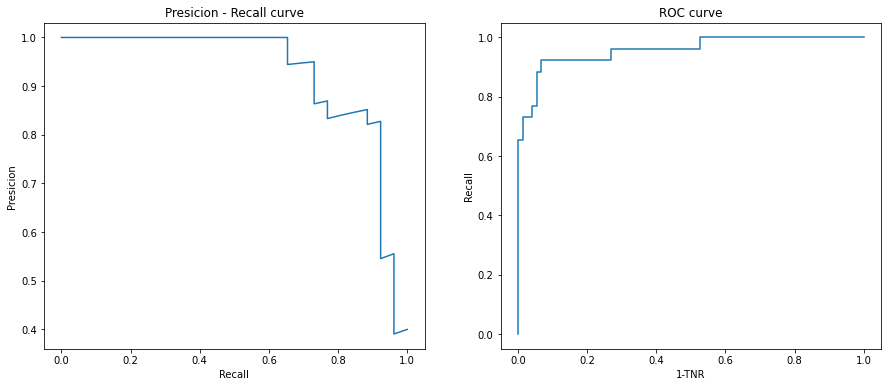

In [11]:
dict_curves_test = compute_curves(Y_test, y_test_predict, pos_label=0, plot=True)

precision-recall curve for the class  2


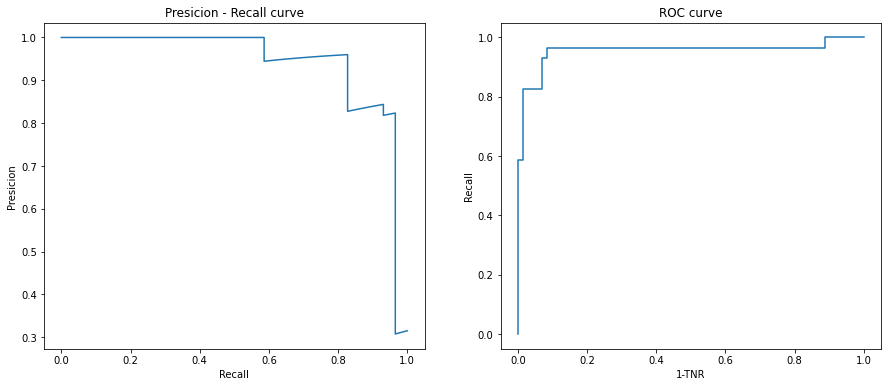

In [13]:
dict_curves_test = compute_curves(Y_test, y_test_predict, pos_label=2, plot=True)

<Figure size 432x288 with 0 Axes>

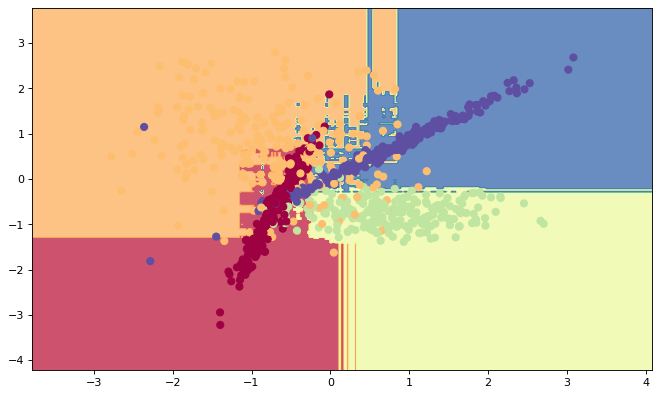

<Figure size 432x288 with 0 Axes>

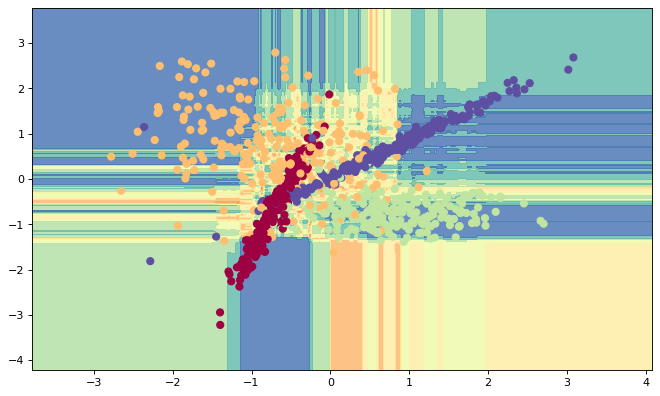

In [14]:
values = ploting_probilities_surfaces(X_train_scaled.values, Y_train.values, model, figsize=(10, 6))